# Fairness, Accountability, Transparency and Ethics Course (FATE)

## Universitat Pompeu Fabra (UPF)
### Academic Year 2025-2026
### Author: Ashwin Singh (ashwin.singh01@estudiant.upf.edu)

Submission date: 20/02/2025 at 23:59 on Aula Global

Please work on this notebook **individually**.

# Getting Started

## Installs & Imports

In [430]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

from prettytable import PrettyTable
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib
import warnings

warnings.filterwarnings(action="ignore")

# Discrimination in Salaries

> [Žliobaitė, I., Custers, B. Using sensitive personal data may be necessary for avoiding discrimination in data-driven decision models. Artificial Intelligence & Law 24, 183–201 (2016).](https://doi.org/10.1007/s10506-016-9182-5)

## Data Overview

This dataset contains the salaries of 52 faculty (38 Male, 14 Female) from a small midwestern college in United States from the early 1980s.


In [431]:
data_url = "https://raw.githubusercontent.com/Ashwin-19/UPF-FATE-2025/refs/heads/main/Lab%20II%20-%20Algorithmic%20Fairness/Data/salary.dat"

data = pd.read_fwf(data_url)

data.rename(
    columns={
        "sx":"sex",          # sex of the processor
        "rk":"rank",         # rank as a professor
        "dg":"degree",       # highest degree obtained
        "yd":"experience",   # years since highest degree ~ proxy for years of experience
        "sl":"salary"        # salary of the processor
    },
    inplace=True
)

# years spent in current rank, not relevant to the task
data.drop(columns=["yr"],inplace=True)

data.head()

,sex,rank,degree,experience,salary
0,male,full,doctorate,35,36350
1,male,full,doctorate,22,35350
2,male,full,doctorate,23,28200
3,female,full,doctorate,27,26775
4,male,full,masters,30,33696


## Exploratory Data Analysis [ 2 pts ]

Based on the plots below, (a) Which sex would you designated as the protected group and Why? (b) What are the main distributional differences between the protected and unprotected group in terms of how salary varies by years of experience, rank and degree?

**[ Answer ]**

a) I would designate the female sex as the protected group, because they consistently make less than their male counterparts.

b) For the same years of experience women's slope is lower, meaning they earn less. Both for rank and degree, women make less than men in each category.


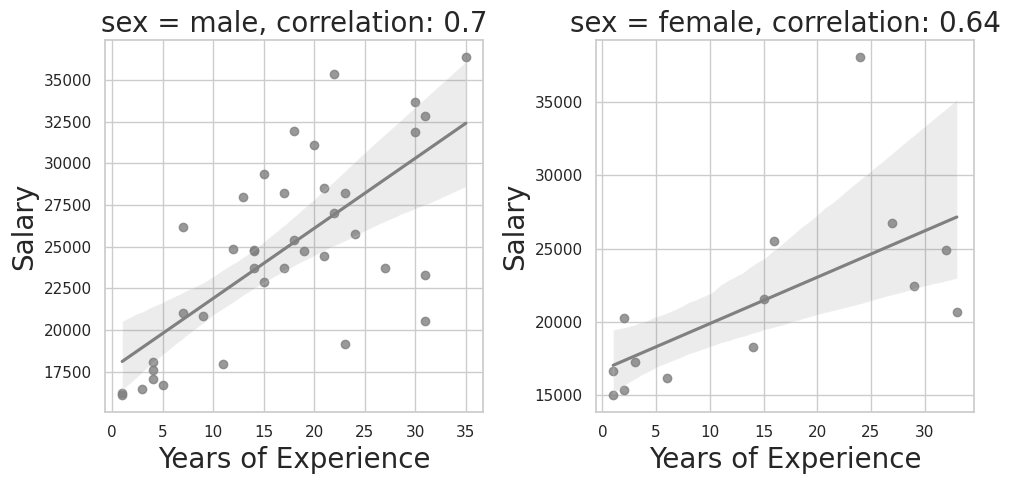

In [432]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(10)

sns.set_theme(style="whitegrid")

sns.regplot(
    data = data[data.sex=="male"],
    x = "experience",
    y = "salary",
    color = "gray",
    ax = ax1
)

sm, pm = pearsonr(
    data[data.sex=="male"].experience,
    data[data.sex=="male"].salary
)

ax1.set_title(
    f"sex = male, correlation: {round(sm,2)}",
    fontsize = 20
)
ax1.set_xlabel("Years of Experience", fontsize=20)
ax1.set_ylabel("Salary", fontsize=20)

sns.regplot(
    data = data[data.sex=="female"],
    x = "experience",
    y = "salary",
    color = "gray",
    ax = ax2
)

sf, pf = pearsonr(
    data[data.sex=="female"].experience,
    data[data.sex=="female"].salary
)

ax2.set_title(
    f"sex = female, correlation: {round(sf,2)}",
    fontsize = 20
)
ax2.set_ylabel("Salary", fontsize=20)
ax2.set_xlabel("Years of Experience", fontsize=20)

plt.tight_layout()
plt.show()

In [433]:
data.groupby("sex")["rank"].value_counts(normalize=True)

sex     rank     
female  assistant    0.571429
        full         0.285714
        associate    0.142857
male    full         0.421053
        associate    0.315789
        assistant    0.263158
Name: proportion, dtype: float64

In [434]:
data.groupby("sex").degree.value_counts(normalize=True)

sex     degree   
female  doctorate    0.714286
        masters      0.285714
male    doctorate    0.631579
        masters      0.368421
Name: proportion, dtype: float64

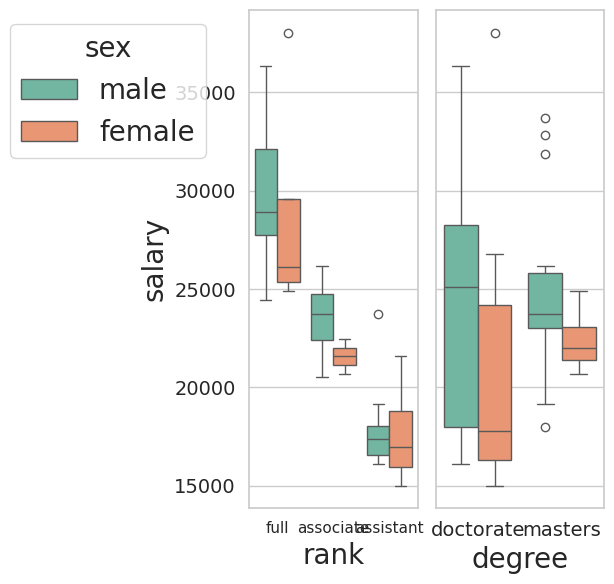

In [435]:
sns.set_theme(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(8)

sns.boxplot(data=data, x="rank", y="salary", hue="sex", ax=ax1, palette="Set2")
sns.boxplot(data=data, x="degree", y="salary", hue="sex", ax=ax2, palette="Set2")

sns.move_legend(ax1, "upper left", bbox_to_anchor=(-1.5, 1), fontsize=20)
plt.setp(ax1.get_legend().get_title(), fontsize=20)
ax2.get_legend().set_visible(False)

L1 = [ ax1.xaxis.label, ax1.yaxis.label, ax2.xaxis.label ]
L2 = ax1.get_yticklabels() + ax2.get_xticklabels()
for item in L1: item.set_fontsize(20)
for item in L2: item.set_fontsize(14)

ax2.set_yticklabels([])
ax2.set_ylabel("")

plt.tight_layout()
plt.show()

## Preprocessing Data

In [436]:
def preprocess(data):

    # encode ordinal variables on a scale of 1 to n
    data["rank"] = data["rank"].map(
        lambda rank: {"full":3, "associate":2, "assistant":1}[rank]
    )

    data.degree = data.degree.map(
        lambda degree: {"doctorate":2, "masters":1}[degree]
    )

    # encode gender as one-hot without introducing a dummy variable
    data.sex = data.sex.map(
        lambda sex: {"female":1, "male":0}[sex]
    )

    return data

processed = preprocess(data.copy())
processed.head()

,sex,rank,degree,experience,salary
0,0,3,2,35,36350
1,0,3,2,22,35350
2,0,3,2,23,28200
3,1,3,2,27,26775
4,0,3,1,30,33696


## A Test of Fairness via "Unawareness" - Linear Regression

In [437]:
def fit_regression_model(data,features,target):
    model = LinearRegression()
    model.fit(
        X = data[features],
        y = data[target]
    )
    return model

In [438]:
def make_regression_formula_table(models,sensitive=["sex"]):

    features = models["aware_model"].feature_names_in_

    T = PrettyTable(
        field_names = ["Model","intercept"] + list(features)
    )

    for model_name in models:

        model = models[model_name]
        coefs = list(model.coef_)
        for A in sensitive:
            if A not in model.feature_names_in_:
                coefs += [0]

        coefs = list(map(lambda x: round(x,3),coefs))
        intercept = round(model.intercept_,3)

        row = [model_name,intercept] + coefs
        T.add_row(row)

    print(T)

In [439]:
blind_features = ["rank", "degree", "experience"]
aware_features = blind_features + ["sex"]

models = {

    "aware_model":fit_regression_model(
        data = processed,
        features = aware_features,
        target = "salary"
    ),

    "blind_model":fit_regression_model(
        data = processed,
        features = blind_features,
        target = "salary"
    ),

    "m_model":fit_regression_model(
        data = processed[processed.sex==0],
        features = blind_features,
        target = "salary"
    ),

    "f_model":fit_regression_model(
        data = processed[processed.sex==1],
        features = blind_features,
        target = "salary"
    )
}

In [440]:
make_regression_formula_table(models)

+-------------+-----------+----------+----------+------------+----------+
|    Model    | intercept |   rank   |  degree  | experience |   sex    |
+-------------+-----------+----------+----------+------------+----------+
| aware_model | 11558.084 | 4993.251 | 397.715  |  102.948   | -950.046 |
| blind_model | 11424.746 | 5230.64  | 179.316  |   87.735   |    0     |
|   m_model   | 11736.019 | 5031.594 |  -30.61  |  129.252   |    0     |
|   f_model   |  7718.572 | 4567.12  | 2398.652 |   115.91   |    0     |
+-------------+-----------+----------+----------+------------+----------+


## Error Analysis

In [441]:
processed["pred_aware"] = models["aware_model"].predict(processed[aware_features])
processed["pred_blind"] = models["blind_model"].predict(processed[blind_features])

df_m, df_f = processed[processed.sex==0], processed[processed.sex==1]

error_table = PrettyTable(field_names = ["model","error_male","error_female"])

em_aware = root_mean_squared_error(
    df_m.pred_aware, df_m.salary
)

ef_aware = root_mean_squared_error(
    df_f.pred_aware, df_f.salary
)

error_table.add_row(["aware",round(em_aware,2), round(ef_aware,2)])

em_blind = root_mean_squared_error(
    df_m.pred_blind, df_m.salary
)

ef_blind = root_mean_squared_error(
    df_f.pred_blind, df_f.salary
)

error_table.add_row(["blind",round(em_blind,2), round(ef_blind,2)])
print(error_table)

+-------+------------+--------------+
| model | error_male | error_female |
+-------+------------+--------------+
| aware |   2558.4   |   3454.03    |
| blind |  2565.68   |   3524.82    |
+-------+------------+--------------+


## Faculty Hiring Scenario [ 6 pts ]

Suppose you are hired as an administrator at this university, and it is upto you to determine salaries for newly hired faculty. You decide to use a **Linear Regression** model for this task, based on the information about the current faculty available to you.

**[ 1 pts ]** You are provided with information about their rank as a professor, highest degree obtained and years of experience, but the hiring committee emphasizes on fairness and refuses to share information about the sex of the current faculty. How do you convince them to do otherwise?



**[ Answer ]**

I try to convince them by explainig that using the variable sex in the linear regression will train a more accurate and fair model. Of course, after the model is ready, sex should not be required as an input variable for decision making.


**[ 1 pts ]** In response to your argument, one of the hiring committee members insists on building separate models for both protected groups in your data to minimize errors for each group. What are the limitations of this approach?

**[ Answer ]**

By training models on the basis of gender, when we know that gender plays a role in the salary, instead of removing bias we reinforce it. It is more accurate, but that does not serve our purpose of removing discrimination.

**[ 4 pts ]** Let's say you finally convinced the hiring committee to provide you with information about the sex of the current faculty. Incorporate the same in your model, and show how it leads to fairer outcomes. Can the model still be unfair?

**Hint I**: How can you eliminate the dependency of salary on the sensitive attribute, or alternatively, how can you make the coefficient of the sensitive attribute "0" in linear regression.

**Hint II**: Read $\S~\text{3.2}$ and $\S~\text{4}$ of
> Žliobaitė, I., Custers, B. Using sensitive personal data may be necessary for avoiding discrimination in data-driven decision models. Artificial Intelligence & Law 24, 183–201 (2016). https://doi.org/10.1007/s10506-016-9182-5



In [442]:
def correct_data(data,sensitive,protected,coef,target):
    """
    Corrects the data for fairness

    Args:
        data (pandas.DataFrame): data to be corrected
        sensitive (str): column of sensitive attribute
        protected (str): protected group within sensitive attribute
        coef (float): coefficeint of sensitive attribute in the model
        target (str): column of the target variable

    Returns:
        pandas.DataFrame: corrected data

    """
    corrected_data = data.copy()

    # Convert 'sensitive' column into a binary variable (1 for males, 0 for females)
    corrected_data['s'] = (corrected_data[sensitive] != protected).astype(int)

    # Adjust salary based on the sensitive attribute value
    mean_s = corrected_data['s'].mean()

    corrected_data[target] -= coef * (mean_s)

    corrected_data = corrected_data.drop('s', axis=1)

    return corrected_data

In [443]:
corrected = correct_data(
    data,
    "sex",
    "female",
    -950.046,
    "salary"
 )
corrected

,sex,rank,degree,experience,salary
0,male,full,doctorate,35,37044.264385
1,male,full,doctorate,22,36044.264385
2,male,full,doctorate,23,28894.264385
3,female,full,doctorate,27,27469.264385
4,male,full,masters,30,34390.264385
5,male,full,doctorate,21,29210.264385
6,female,full,masters,32,25594.264385
7,male,full,doctorate,18,32603.264385
8,male,full,masters,30,32544.264385
9,male,full,masters,31,33544.264385


**[ Answer ]**

With the algorithm we manage to remove bias by subtracting the coefficent.
But the model can still be unfair because there still might be hidden bias in other features or the bias could be of nonlinear nature.

# Success in Law School

## Data Overview

The Law School Admission Council conducted a survey across 163 law schools in the United States in 1998. It contains information on 21,790 law students such as their entrance exam scores (LSAT), their grade-point average (GPA) collected prior to law school, and their first year average grade (FYA) in law school.

The dataset contains **Z-Scores** for FYA, i.e., if F denotes the set of first year average grades, each $f \in F$ is transformed as:

$Z(f) = \frac{f-\mu_{F}}{\sigma_{F}}$

In [444]:
law_data_url = "https://raw.githubusercontent.com/Ashwin-19/UPF-FATE-2025/refs/heads/main/Lab%20II%20-%20Algorithmic%20Fairness/Data/law_data.csv"

law_data = pd.read_csv(
    law_data_url,
    index_col = 0
)

law_data.sex = law_data.sex.map(lambda s: {1:"female", 2:"male"}[s])
law_data = law_data[["race","sex","LSAT","UGPA","ZFYA"]]

law_data.head()

,race,sex,LSAT,UGPA,ZFYA
0,White,female,39.0,3.1,-0.98
1,White,female,36.0,3.0,0.09
2,White,male,30.0,3.1,-0.35
5,Hispanic,male,39.0,2.2,0.58
6,White,female,37.0,3.4,-1.26


The data is split into train set and test set in an 80-20 ratio, shuffled for randomization and stratified across sensitive attributes.

In [452]:
train, test = train_test_split(
    law_data,
    test_size = 0.2,
    stratify = law_data[["race", "sex"]],
    shuffle = True
)
train

,race,sex,LSAT,UGPA,ZFYA
12898,White,female,34.0,3.1,0.45
420,White,male,39.0,2.4,-0.10
22915,White,female,31.5,3.0,-1.50
21950,White,male,33.0,3.0,0.59
1369,White,male,41.0,3.5,0.86
...,...,...,...,...,...
1471,Hispanic,male,35.0,2.9,-1.56
20651,Asian,male,45.0,3.6,-0.96
25650,White,female,40.0,3.0,0.75
3640,White,male,34.0,3.0,0.28


## ZFYA prediction [ 2 pts ]

**[ 2 pts ]** Similar to the previous exercise, preprocess the training data and train linear regression models for predicting $Z(f)$ which are (a) blind to sensitive attributes, and (b) aware of sensitive attributes. What do you observe from the model coefficients?

⚠️ Do not fall into the [dummy variable trap](https://en.wikipedia.org/wiki/Dummy_variable_(statistics#Precautions_in_the_usage_of_dummy_variables) during preprocessing.

In [454]:
# your code for preprocessing here

def preprocess(data):

    data["sex"] = data["sex"].map({"female": 1, "male": 0})

    data = pd.get_dummies(data, columns=["race"], drop_first=True).astype(int)

    return data

processed_train = preprocess(train.copy())
processed_test = preprocess(test.copy())
processed_test.head()


,sex,LSAT,UGPA,ZFYA,race_Asian,race_Black,race_Hispanic,race_Mexican,race_Other,race_Puertorican,race_White
22190,0,31,3,0,0,0,0,0,0,0,1
1763,0,47,3,0,0,0,0,0,0,0,1
14534,0,35,3,-1,0,0,0,0,0,0,1
4609,0,36,3,0,0,0,0,0,0,0,1
17814,0,35,3,0,0,0,0,0,0,0,1


In [455]:
# Train both models
blind_features = ["LSAT", "UGPA"]
sensitive=['sex',	'race_Asian',	'race_Black',	'race_Hispanic',	'race_Mexican',	'race_Other',	'race_Puertorican',	'race_White']
aware_features = blind_features + sensitive
models = {

    "aware_model":fit_regression_model(
        data = processed_train,
        features = aware_features,
        target = "ZFYA"
    ),

    "blind_model":fit_regression_model(
        data = processed_train,
        features = blind_features,
        target = "ZFYA"
    )
}
make_regression_formula_table(models,sensitive)

+-------------+-----------+-------+-------+--------+------------+------------+---------------+--------------+------------+------------------+------------+
|    Model    | intercept |  LSAT |  UGPA |  sex   | race_Asian | race_Black | race_Hispanic | race_Mexican | race_Other | race_Puertorican | race_White |
+-------------+-----------+-------+-------+--------+------------+------------+---------------+--------------+------------+------------------+------------+
| aware_model |   -1.199  | 0.019 | 0.075 | -0.016 |   0.182    |   -0.041   |     0.205     |    0.128     |   0.355    |      -0.066      |   0.419    |
| blind_model |   -1.231  | 0.027 | 0.109 |   0    |     0      |     0      |       0       |      0       |     0      |        0         |     0      |
+-------------+-----------+-------+-------+--------+------------+------------+---------------+--------------+------------+------------------+------------+


**[ Answer ]**

The aware model assigns a small negative coefficient (-0.036) to sex, meaning that female sex has a slightly lower predicted outcome, by the same logic we can see the connection of race and predicted outcome. White has the highest predicted outcome; Other , Hispanic, Asian, Mexican, a lower but still positive outcome. Black and Puertorican a negative one.

The blind model does not take into consideration either race or gender in the prediction and has a higher intercept and overall higher values.



## Counterfactual Fairness [ 5 pts ]

A decision is **counterfactually fair** towards an individual if it the same in (a) the actual world and (b) a counterfactual world where the individual belonged to a different demographic group.

Formally, $Y \perp \!\!\! \perp A \;|\; X \implies$  A predictor $Y$ is **counterfactually fair** if under any context $\;X = x,\;A = a\;$, $Y$ satisfies the following:

$\mathbb{E}\;[\;Y\;|\;X = x,\;A = a\;] = \mathbb{E}\;[\;Y\;|\;X = x,\;A = a'\;] $



---



> [Matt Kusner, Joshua Loftus, Chris Russell, and Ricardo Silva. 2017. Counterfactual fairness. In Proceedings of the 31st International Conference on Neural Information Processing Systems (NIPS'17)](https://papers.nips.cc/paper_files/paper/2017/file/a486cd07e4ac3d270571622f4f316ec5-Paper.pdf).

**[ 4 pts ]** Using the aware model, draw predictions on the test-set to find two combinations of race and sex  where the model over-predicts $Z(f)$ upon counterfactually changing the (a) race, and (b) sex of the law-school applicant.  

For both cases, plot the distribution (histograms) of the actual $Z(f)$, normally predicted $Z(f)$, and counterfactually predicted $Z(f)$ by the model. What do you observe?

Can you come up with a metric which measures counterfactual discrimination i.e., the extent to which a predictor $Y$ does not satisfy **counterfactual fairness**, given group $a$ and corresponding counterfactual group $a'$. Report the metric for both (a) and (b).


<!-- You are free to choose the groups as long as they satisfy $\mathbb{E}[Z(f)|a=1] < \mathbb{E}[Z(f)|a=0]$.  -->

<!-- **[ 1 pts ]** Plot the distribution of $Z(f)$ for both the protected and unprotected group (histogram / kdeplot etc.). Also report their mean and standard deviation. -->

In [460]:
# your code for predictions and plotting here

# 2 combinations of over-prediction

import numpy as np

# Preprocess test set and get predictions
X_test, y_test = processed_test[aware_features], test["ZFYA"]
test_predictions = models["aware_model"].predict(X_test)

# # Counterfactual changes
# counterfactual_race = X_test.copy()
# counterfactual_race.loc[:, ['race_Asian', 'race_Black', 'race_Hispanic', 'race_Mexican', 'race_Other', 'race_Puertorican', 'race_White']] = 0
# counterfactual_race["race_Black"] = 1  # Example race change

# counterfactual_sex = X_test.copy()
# counterfactual_sex["sex"] = 1 - counterfactual_sex["sex"]  # Flip sex

# # Get counterfactual predictions
# race_diff = test_predictions - models["aware_model"].predict(counterfactual_race)
# sex_diff = test_predictions - models["aware_model"].predict(counterfactual_sex)

# # Identify the most over-predicted cases
# over_predicted_race = test.iloc[np.argmax(race_diff)]
# over_predicted_sex = test.iloc[np.argmax(sex_diff)]

# # Print results
# print("Over-predicted case upon changing race:\n", over_predicted_race)
# print("\nOver-predicted case upon changing sex:\n", over_predicted_sex)


In [ ]:
# your code for discrimination metric here

**[ Answer ]**

**[ 1 pts ]** Theoretically, one could argue that a model blind to sensitive attributes satisfies **counterfactual fairness**, as for any blind model

$\forall a \in A \;\; \mathbb{E}\;[\;Y\;|\;X = x,\;A = a\;] = \mathbb{E}\;[\;Y\;|\;X = x\;]$

$\therefore \mathbb{E}\;[\;Y\;|\;X = x,\;A = a\;] = \mathbb{E}\;[\;Y\;|\;X = x,\;A = a'\;] = \mathbb{E}\;[\;Y\;|\;X = x\;]$

Is this argument incorrect, or is it a limitation of **counterfactual fairness**? Explain.

**[ Answer ]**

## Statistical (or Demographic) Parity [ 8 pts ]

A prediction satisfies statistical parity if it is independent of the sensitive attribute.

Formally, $Y \perp \!\!\! \perp A \; \implies$ A predictor $Y$ satisfies *statistical parity* if  $\;\forall a \in A \;\;\; P \;[\;Y \geq z \;|\;A = a\;] = P \;[\;Y \geq z\;]$



> [Agarwal, A., Dudik, M. &amp; Wu, Z.S.. (2019). Fair Regression: Quantitative Definitions and Reduction-Based Algorithms. <i>Proceedings of the 36th International Conference on Machine Learning</i>, in <i>Proceedings of Machine Learning Research</i>.](https://proceedings.mlr.press/v97/agarwal19d.html)


**[ 4 pts ]** Use a **pre-processing** intervention from [T09.B.15](https://docs.google.com/presentation/d/1SMYX3DTw4KEbq-rjJ2iID-nQNVAZfNU7n8T3l_vH6lY/present) to train a linear regression predictor satisfying **statistical parity** for all combinations of race-sex. Make two CDF plots of the predicted $Z(f)$ by the model on the training set, colored by (a) race and (b) sex to show the same.

⚠️ Ensure that you use the same mechanism as the train set to transform values in the test set.

In [ ]:
# your code for preprocessing and model-training here

In [ ]:
# your code for predictions and plotting here

**[ Answer ]**

**[ 4 pts ]**  Now, make the same two CDF plots of the predicted  𝑍(𝑓)  by the model on the **test set**, colored by (a) race and (b) sex. Does the model still satisfy **statistical parity** for both sensitive attributes? If not, explain why - you may use a metric for the same.

In [ ]:
# your code for predictions and plotting here

## Law School Admission Scenario [ 2 pts ]

Suppose you are incharge of admitting new students at a prestigious state university. You decide to use a **Linear Regression** model for this task, based on the current students' LSAT, UGPA and demographic attributes to predict their ZFYA (proxy of sucess) at the university. Describe one scenario in which you would use a model which is **counterfactually fair**, and one scenario where you would use a model which satisfies **statistical (or demographic) parity**. Explain your reasoning.

**[ Answer ]**